In [1]:
!pwd

/home/petros/ATHENA/agro4+/grapes/penducles


In [2]:
import os
os.chdir('../')

In [3]:
!pwd

/home/petros/ATHENA/agro4+/grapes


In [4]:
import logging

In [5]:
import torch

In [6]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import ( COCOEvaluator,
    verify_results,
    inference_context,
    inference_on_dataset
)

In [7]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
# import detectron2.utils.comm as comm
import time
import datetime

In [8]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [9]:
torch.cuda.is_available()

True

In [10]:
!ls 'penducles'

labelme2coco.py  test	     test.json	train.json  val       val_og
penducles.ipynb  test.ipynb  train	train_og    val.json


In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("penducles_train",)
cfg.DATASETS.TEST = ("penducles_val",)
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5_000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# cfg.OUTPUT_DIR = './penducles_output'

In [12]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        # comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [13]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, ('bbox', 'segm'), True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [14]:
for d in ["train", "test", "val"]:
    register_coco_instances(f"penducles_{d}", {}, f"penducles/{d}.json", f"penducles/{d}")

In [15]:
dataset_dicts = DatasetCatalog.get("penducles_train")
penducles_metadata = MetadataCatalog.get("penducles_train")

WARNING [12/05 08:44:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/05 08:44:59 d2.data.datasets.coco]: Loaded 253 images in COCO format from penducles/train.json


In [16]:
# for d in random.sample(dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     v = Visualizer(img[:, :, ::-1], metadata=clusters_metadata, scale=0.5)
#     v = v.draw_dataset_dict(d)
#     plt.figure(figsize = (14, 10))
#     plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
#     plt.show()

In [1]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
# cfg.DATASETS.TEST = ("penducles_test", )
predictor = DefaultPredictor(cfg)

In [18]:
# from detectron2.utils.visualizer import ColorMode
# im = cv2.imread('./penducles/test/DSC07692.JPG')
# outputs = predictor(im)
# v = Visualizer(im[:, :, ::-1],
#                 metadata=penducles_metadata, 
#                 scale=0.8, 
#                 instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
# )
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.figure(figsize = (14, 10))
# plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
# plt.show()

WARNING [12/05 09:25:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/05 09:25:56 d2.data.datasets.coco]: Loaded 37 images in COCO format from penducles/test.json


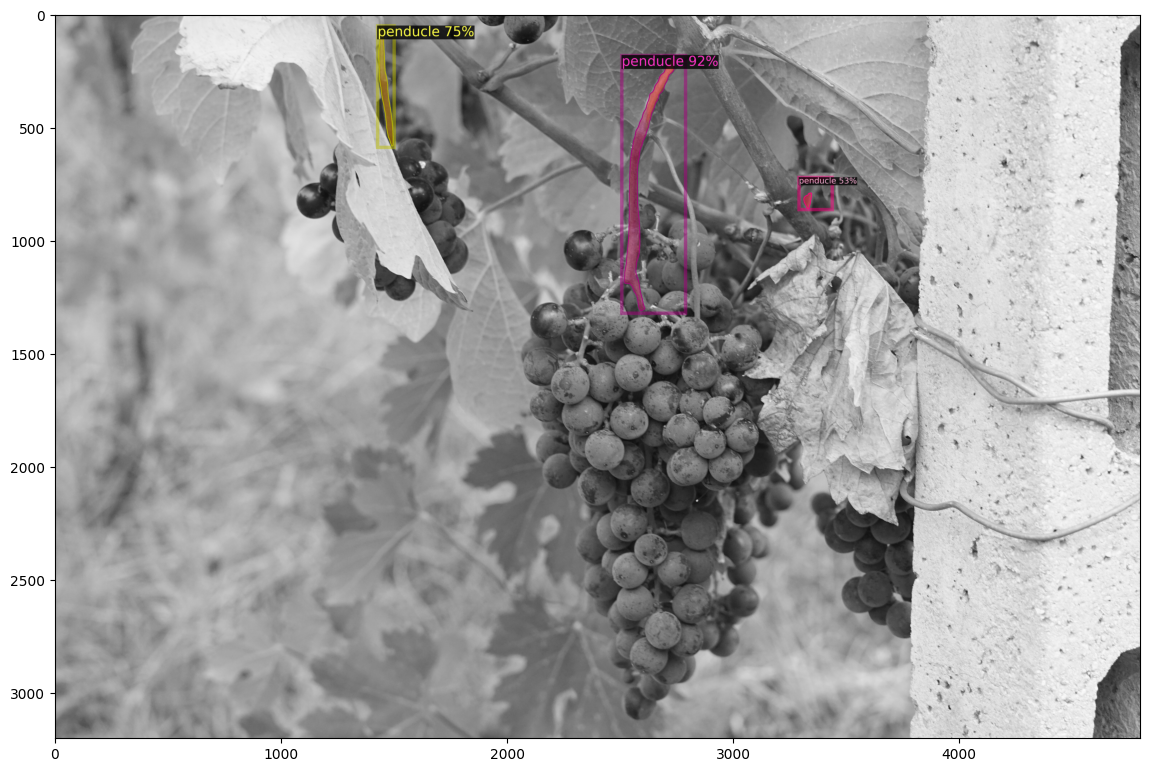

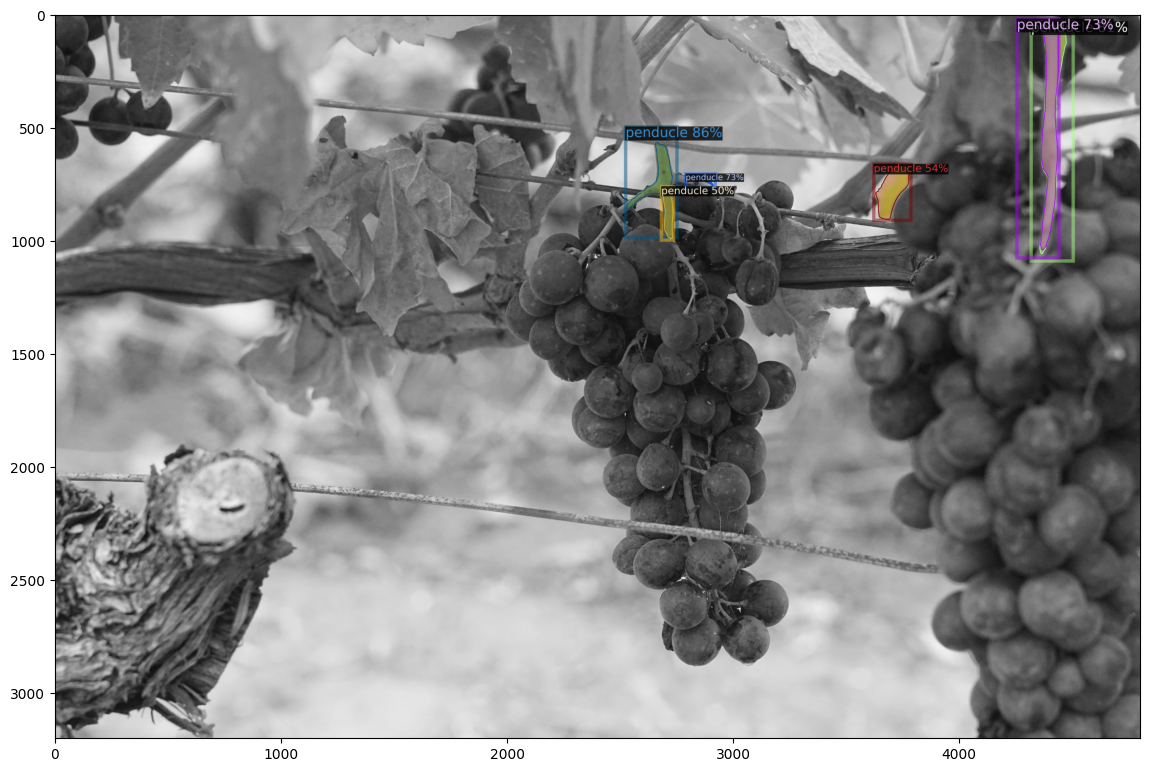

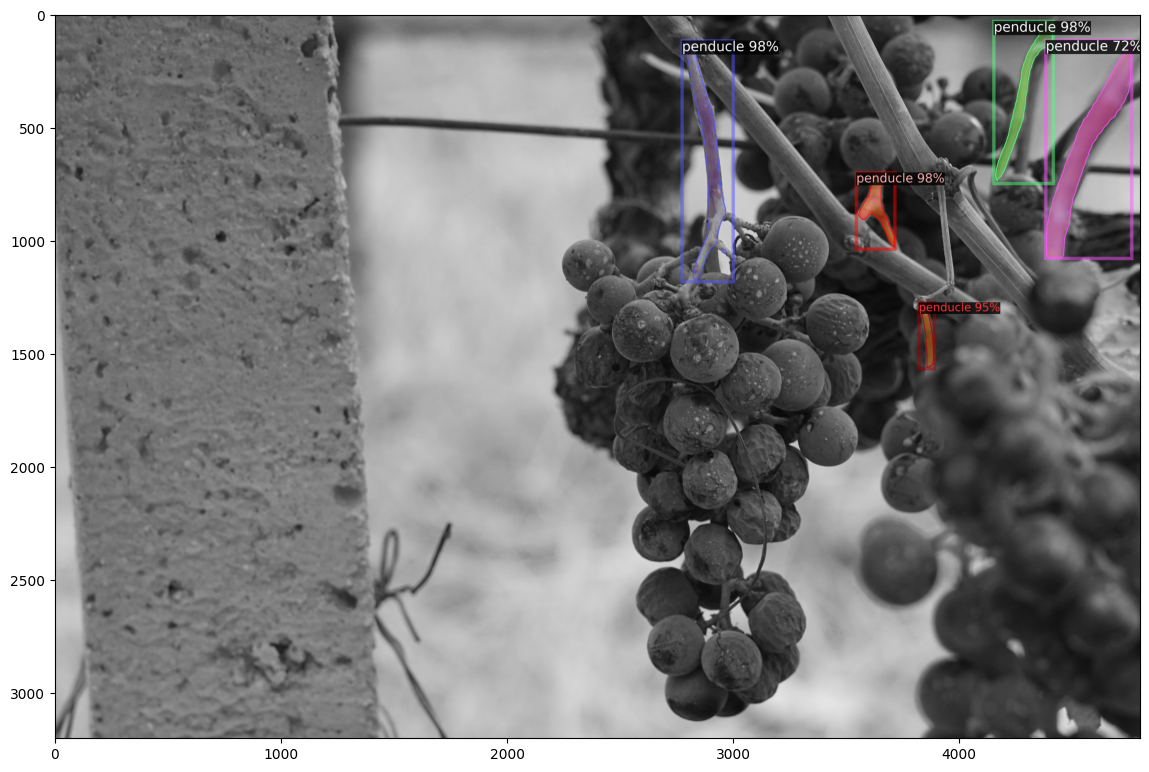

In [19]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("penducles_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=penducles_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

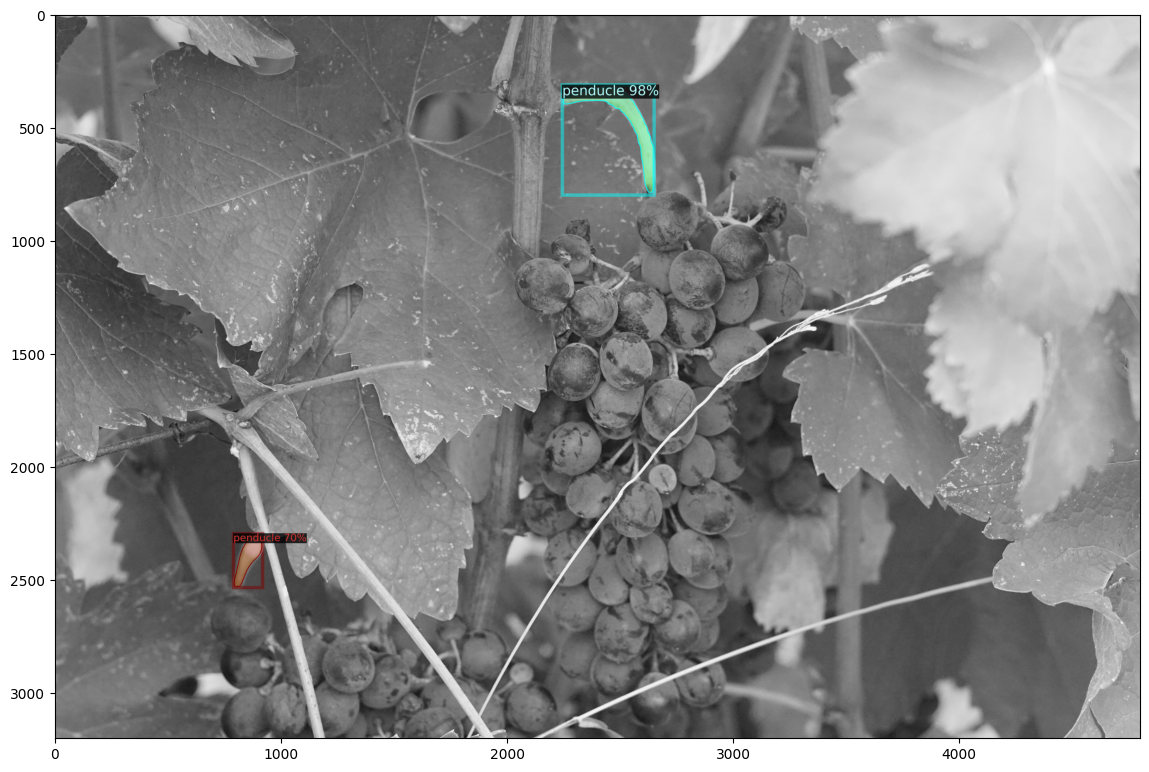

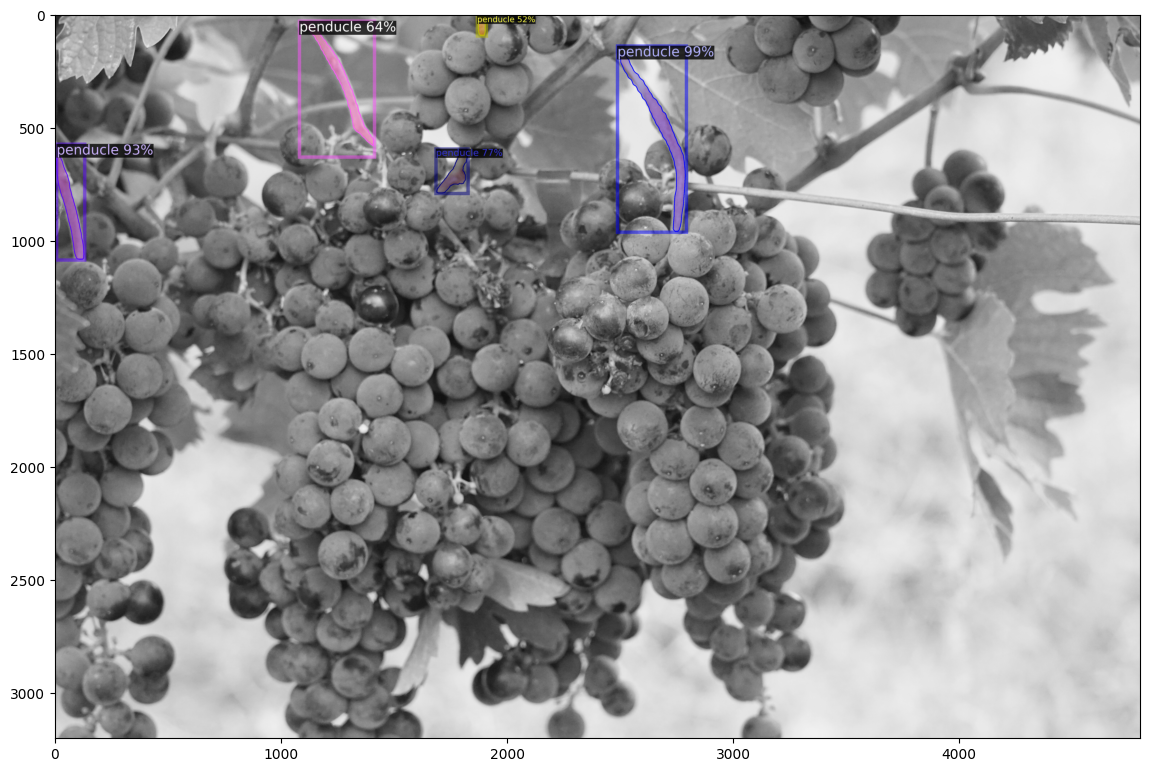

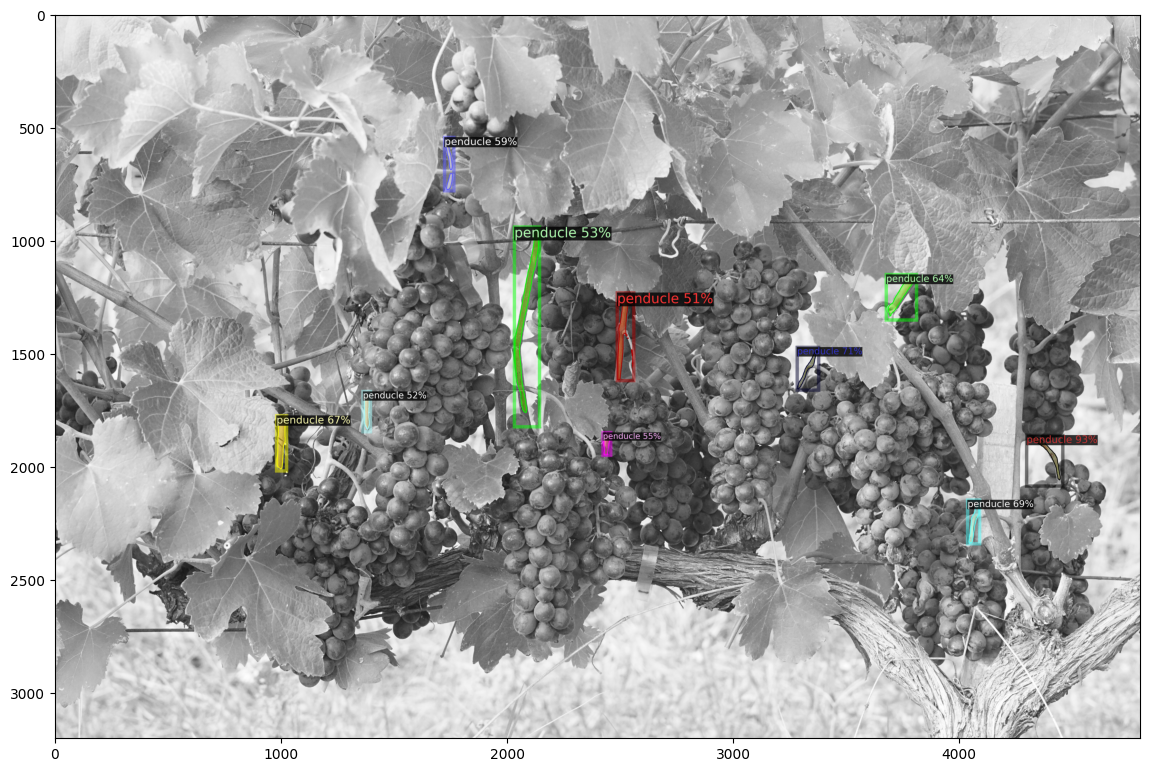

In [19]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata= penducles_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

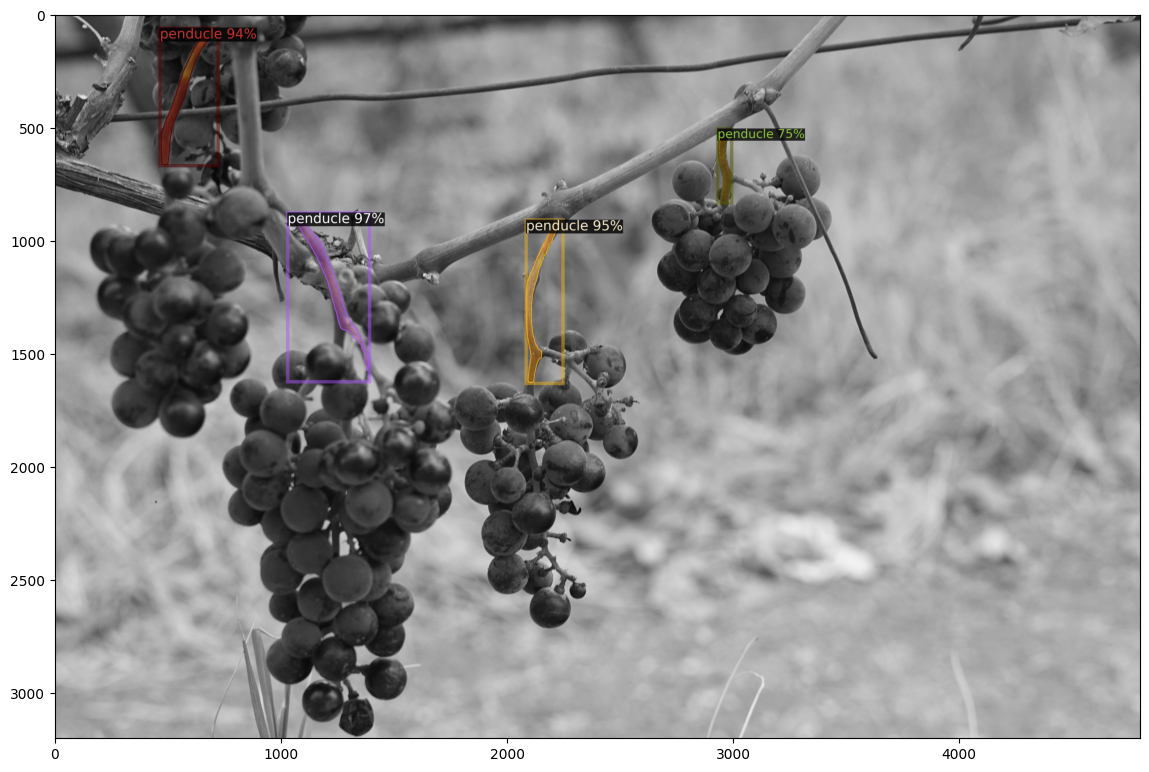

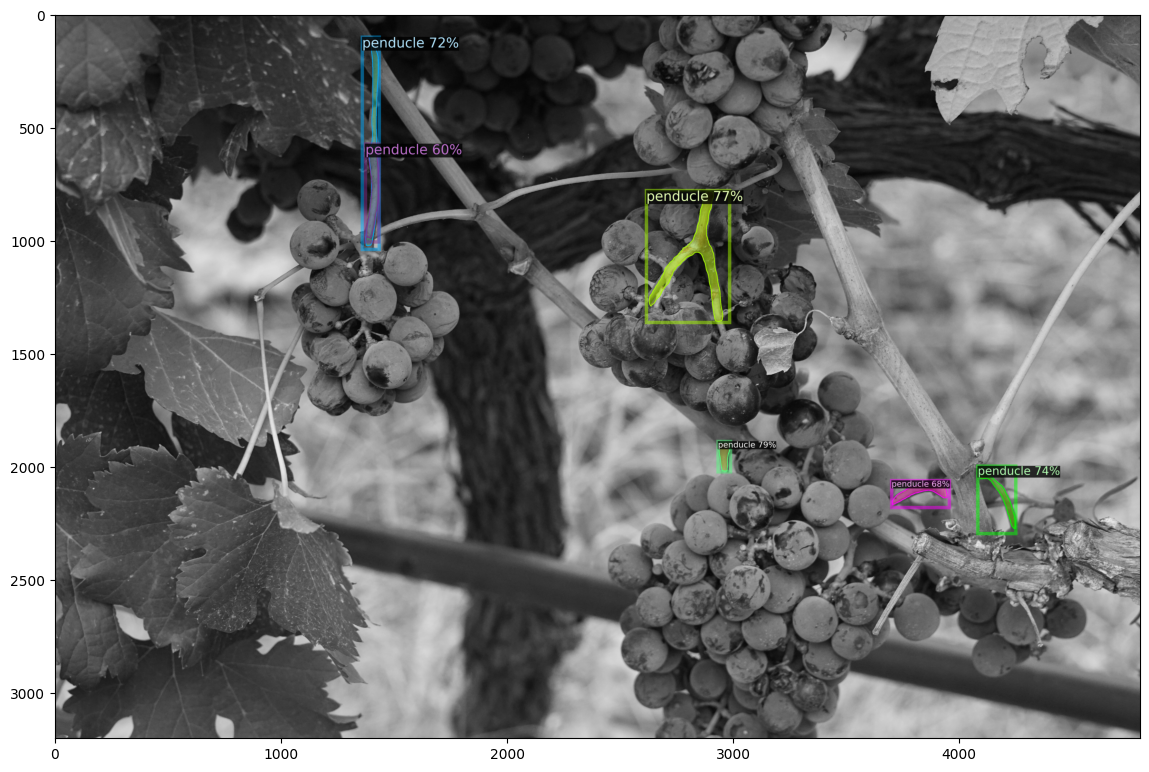

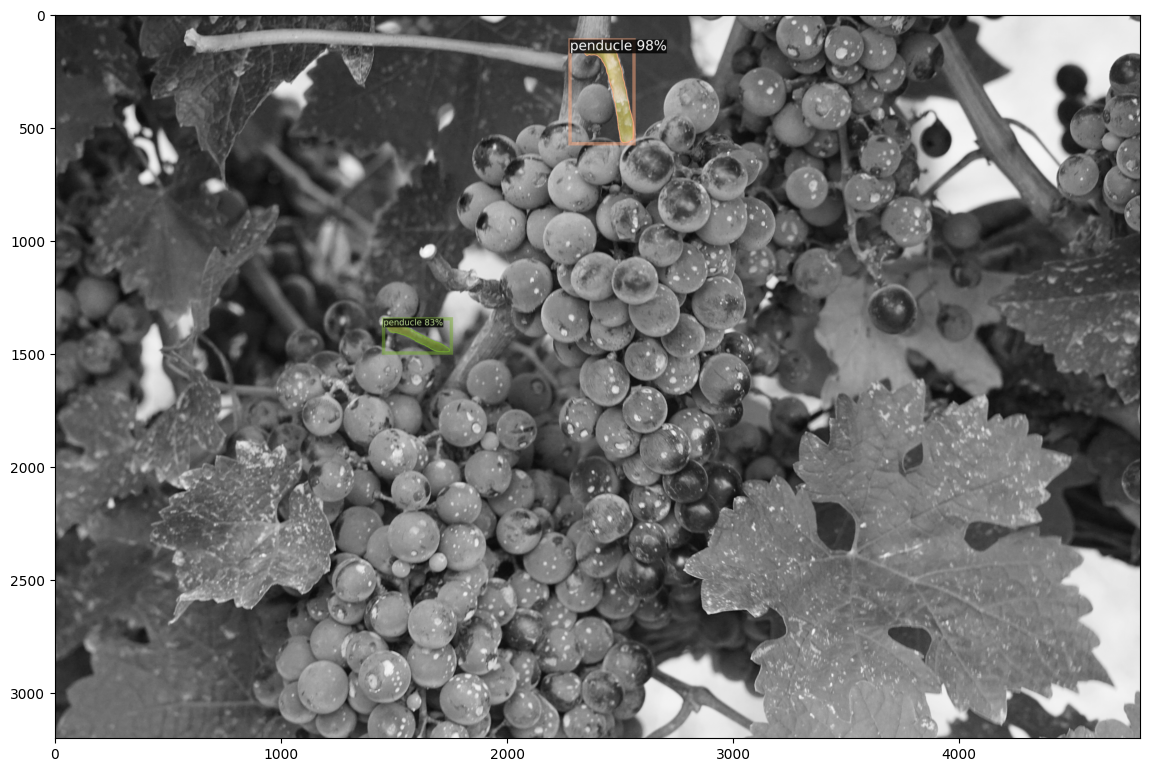

In [20]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=clusters_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()